**Dataset**:

Primary Dataset: Use the NYC Taxi Trip Dataset yellow taxi trip records

Timeframe: Only use the data from December 2024

**Task Requirements**

***Data ingestion stage***

In [2]:
from pyspark.sql import SparkSession

Initiatize Spark session

In [5]:
spark = SparkSession.builder\
                    .appName("Taxi drive analysis")\
                     .getOrCreate()

Load data into dataframe

In [ ]:
# The schema was infereed automatically with True(InferSchema)
ingested_df = spark.read.format('parquet').option('InferSchema', True)\
                        .option('header', True)\
                        .option('multiline', False)\
                        .load('/data/yellow_tripdata_2024-12.parquet')

In [57]:
# If explcitly defined
from pyspark.sql.types import StructType, StructField, IntegerType, TimestampType, FloatType, LongType, StringType
revised_schema = StructType([
     StructField("VendorID", IntegerType(), True),
    StructField("tpep_pickup_datetime", TimestampType(), True),
    StructField("tpep_dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", LongType(), True),
    StructField("trip_distance", FloatType(), True),
    StructField("RatecodeID", IntegerType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("PULocationID", IntegerType(), True),
    StructField("DOLocationID", IntegerType(), True),
    StructField("payment_type", IntegerType(), True),
    StructField("fare_amount", FloatType(), True),
    StructField("extra", FloatType(), True),
    StructField("mta_tax", FloatType(), True),
    StructField("tip_amount", FloatType(), True),
    StructField("tolls_amount", FloatType(), True),
    StructField("improvement_surcharge", FloatType(), True),
    StructField("total_amount", FloatType(), True),
    StructField("congestion_surcharge", FloatType(), True),
    StructField("Airport_fee", IntegerType(), True)
])

Display the dataframe

In [8]:
ingested_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-12-01 00:12:27|  2024-12-01 00:31:12|              1|         9.76|         1|                 N|         138|          33|           1|       38.0|  6.0|    0.5|      4.7

Display the schema

In [10]:
ingested_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



**Data cleaning task**

Based on requirement, clean the dataset by filtering out invalid or missing data types

In [20]:
from pyspark.sql.functions import col

In [55]:
# Firstly filter out rows with missing data(not null) or invalid data
cleaned_df = ingested_df.filter(
    (col("tpep_pickup_datetime").isNotNull()) &
    (col("tpep_dropoff_datetime").isNotNull()) &
    (col("trip_distance") > 0) &
    (col("fare_amount") > 0) &
    (col("passenger_count") > 0)
)

In [24]:
cleaned_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-12-01 00:12:27|  2024-12-01 00:31:12|              1|         9.76|         1|                 N|         138|          33|           1|       38.0|  6.0|    0.5|      4.7

Ensure proper timestamp format

In [54]:
cleaned_df = cleaned_df.withColumn("tpep_pickup_datetime", col("tpep_pickup_datetime").cast(TimestampType())) \
                       .withColumn("tpep_dropoff_datetime", col("tpep_dropoff_datetime").cast(TimestampType()))

In [26]:
cleaned_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-12-01 00:12:27|  2024-12-01 00:31:12|              1|         9.76|         1|                 N|         138|          33|           1|       38.0|  6.0|    0.5|      4.7

**Transformation Stage**

Calculate a new column representing the trip duration (e.g., difference between drop-off and pickup times).
Extract additional features such as Hour of the day, Day of the week

In [27]:
from pyspark.sql.functions import unix_timestamp, hour, dayofweek, when

In [28]:
transformed_df = cleaned_df.withColumn( "trip_duration",
         (unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 60
)


In [29]:
transformed_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|      trip_duration|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------------+
|       2| 2024-12-01 00:12:27|  2024-12-01 00:31:12|              1|         9.76|         1|                 N|         138| 

In [53]:
# Add a new column for hour of the day and day of the week
transformed_df = transformed_df.withColumn("hour_of_day", hour(col("tpep_pickup_datetime"))) \
                               .withColumn("day_of_week", dayofweek(col("tpep_pickup_datetime")))


In [31]:
transformed_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------------+-----------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|      trip_duration|hour_of_day|day_of_week|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------------+-----------+-----------+
|       2| 2024-12-01 00:12:27|  2024-12-01 00:31:12|  

Add category for trip duration, using distance threshold for short <5, medium for >=5 and less than or equal to 10 and long >10

In [58]:
transformed_df = transformed_df.withColumn(
    "trip_category",
    when(col("trip_distance") < 5, "short") \
    .when((col("trip_distance") >= 5) & (col("trip_distance") < 10), "medium") \
    .otherwise("long")
)

In [33]:
transformed_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------------+-----------+-----------+-------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|      trip_duration|hour_of_day|day_of_week|trip_category|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------------+-----------+-----------+-------------+
|       2| 20

**Aggregation and Analysis stage**

In [36]:
from pyspark.sql.functions import mean, min, max, count

In [37]:
key_stats = transformed_df.select(
           min("trip_duration").alias("min_trip_duration"),
           mean("trip_duration").alias("avg_trip_duration"),
           mean("fare_amount").alias("avg_fare_amount"),
           mean("trip_distance").alias("avg_trip_distance"),
           max("trip_duration").alias("max_trip_duration")
).collect()

Group the data by hour/day and compute:
Total number of trips and Average fare and trip duration per time interval.

In [38]:
# Group by hour and day to compute trip counts and averages
hourly_stats = transformed_df.groupBy("hour_of_day").agg(
                             count("*").alias("total_count_trips"),
                             mean("fare_amount").alias("avg_fare"),
                             mean("trip_duration").alias("avg_duration")
                             ).orderBy("hour_of_day")


In [39]:
transformed_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------------+-----------+-----------+-------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|      trip_duration|hour_of_day|day_of_week|trip_category|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------------+-----------+-----------+-------------+
|       2| 20

In [40]:
daily_stats = transformed_df.groupBy("day_of_week").agg(
                            count("*").alias("total_count_trips"),
                            mean("fare_amount").alias("avg_fare"),
                            mean("trip_duration").alias("avg_duration")
                            ).orderBy("day_of_week")


**Performance optimization stage**

In [41]:
#Caching the dataframe for quicker retrieval and access

transformed_df.cache()

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp, tpep_dropoff_datetime: timestamp, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double, trip_duration: double, hour_of_day: int, day_of_week: int, trip_category: string]

In [42]:
#Lets assume total_amount is the commonly assesed column
partitioned_df = transformed_df.repartition("total_amount")

In [44]:
# Write partitioned dataframe to a disk with bucketering approach
partitioned_df.write.bucketBy(5, "total_amount").sortBy("total_amount").mode("overwrite").saveAsTable("partioned_table")

In [45]:
# Read the partitioned dataframe from the partitioned table
partitioned_df_from_table = spark.read.table("partioned_table")

In [46]:
partitioned_df_from_table.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------------+-----------+-----------+-------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|      trip_duration|hour_of_day|day_of_week|trip_category|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------------+-----------+-----------+-------------+
|       2| 20

**Deploying in Production**

**Data partitioning by date**

*   Data partitioning by date
*   Use bucketing for joins

**Distributed computing & cluster optimization**

*   Effecient cluster sizing.
*   Enable dynamic resource allocation.

**Data pipeline optimization**


*   Incremental processing of the dataset.
*   Use Structured streaming feature to process near real-time data.
*   Orchestrate data retrieval with tools like Airflow, dagster
*   Add soda or great expectation to validate data consistency.



**Monitoring and maintenance**


*   Observability using Datadog, Grafana and inbuilt Spark UI.
*   Enable fault handling and logging for pipeline failures.


**Visualization**

*   Implement interactive dashboard with Looker, Tableau, PowerBi etc.


**Cloud storage**


*   Use cloud storage for scalability
*   Futuristic deployment - use of data warehouse for machine learning and analytics.


**Query optimization**


*   Predicate pushdown (filter data before loading to memory)
*   Avoid shuffles (minimize wide transformation)
*   Use broadcast join if possible









**Visualization & Reporting stage**

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# Change spark dataframe to pandas
hourly_stats_pd = hourly_stats.toPandas()
daily_stats_pd = daily_stats.toPandas()

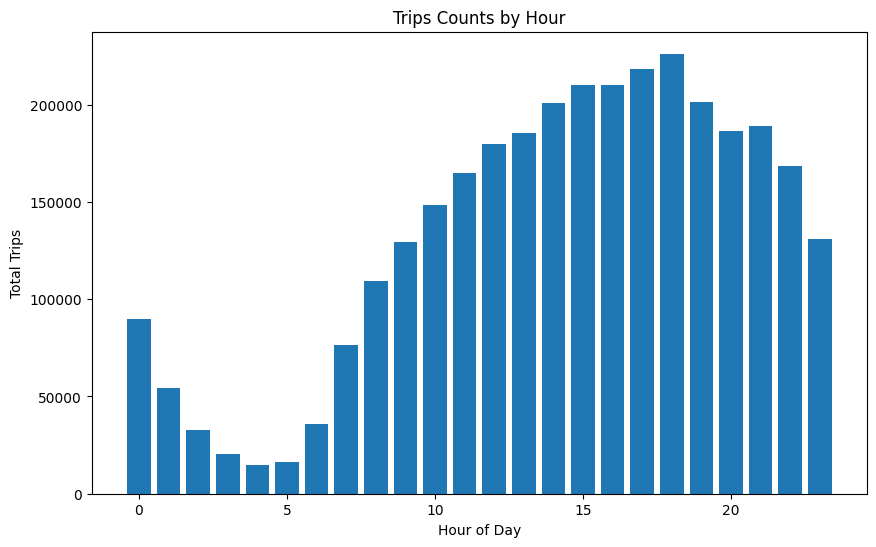

In [51]:
# Plot trip counts by hour
plt.figure(figsize=(10, 6))
plt.bar(hourly_stats_pd["hour_of_day"], hourly_stats_pd["total_count_trips"])
plt.xlabel("Hour of Day")
plt.ylabel("Total Trips")
plt.title("Trips Counts by Hour")
plt.show()


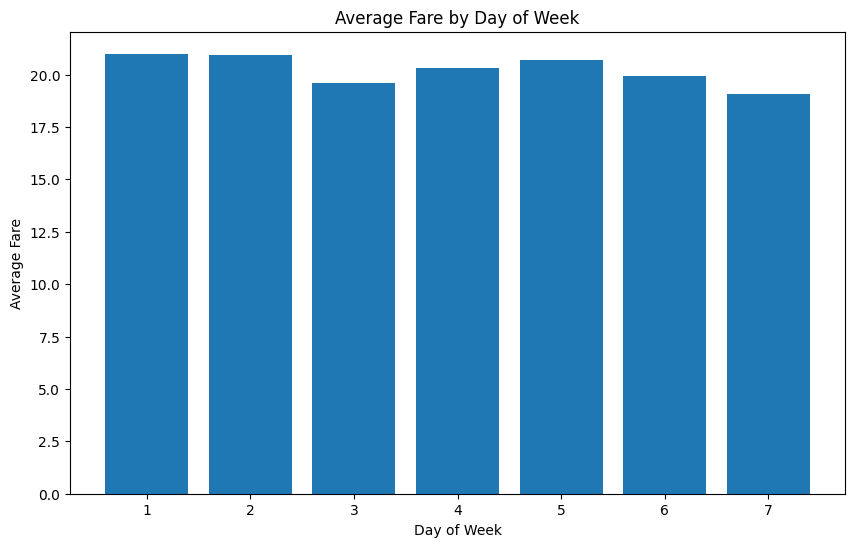

In [52]:
# Plot average fare by day of the week
plt.figure(figsize=(10, 6))
plt.bar(daily_stats_pd["day_of_week"], daily_stats_pd["avg_fare"])
plt.xlabel("Day of Week")
plt.ylabel("Average Fare")
plt.title("Average Fare by Day of Week")
plt.show()